# BTCUSD Dataset 2

In [1]:
import pandas as pd 
import numpy as np
import talib as ta

import os
import pickle

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

import xgboost as xgb

import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
import sklearn.mixture as mix

import shap
import lime

from PIL import Image

import matplotlib.pyplot as plt

from math import sqrt
sqn = lambda x: round(sqrt(sum(~np.isnan(x))) * np.nanmean(x) / np.nanstd(x), 4)
open_close_change = lambda Open, Close: (Close - Open) / Open 

Using TensorFlow backend.


In [2]:
# Function for resampling OHLC data

def resample_ohlc(df, interval = '4H'):

    df_open = df.resample(interval, base = 4)['Open'].first()
    df_high = df.resample(interval, base = 4)['High'].max()
    df_low = df.resample(interval, base = 4)['Low'].min()
    df_close = df.resample(interval, base = 4)['Close'].last()
    df_volume = df.resample(interval, base = 4)['Volume'].sum()
    df = pd.concat([df_open, df_high, df_low, df_close, df_volume], axis = 1)
    
    return df.dropna()


def process_data(df, indicators = ['AOP', 'open_close_change'], n_components = 5):

    filter_indicators = [x for x in indicators] + ['open_close_change']
        
    idx = df[filter_indicators].dropna().index
    X = df[filter_indicators].dropna().values
    
    model = mix.GaussianMixture(n_components = n_components, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
    
    hidden_states = model.predict(X)
    
    # Compose into dataframes and join together; return 
    df_hidden_states = pd.DataFrame(hidden_states, index = idx, columns = ['hidden_state'])
    return df.join(df_hidden_states, how = 'inner')
    

### Creating different datasets to test

I'd like to try the machine learning workflow using a few different test datasets... where each dataset uses a different number of indicators and GMM "components" to create the data

In [3]:
if not os.path.exists("BTCUSD_Dataset2.csv"):
    # Read local data file 
    df_data = pd.read_csv('BTCUSD.csv', error_bad_lines = False)

    # Convert time to datetime format and set as index
    df_data['Time'] = pd.to_datetime(df_data['Time'])
    df_data.set_index('Time', inplace = True)

    # Resample the data for 4-hr OHLC bars

    df_data = resample_ohlc(df_data)

    # Calculate the PnL for the candle from open to close

    df_data['open_close_change'] = df_data.apply(lambda x: open_close_change(x['Open'], x['Close']), axis = 1)

    df_data2 = df_data.copy()

    # Add the indicators to df_data2
    df_data2['MINUS_DM'] = ta.MINUS_DM(df_data['High'], df_data['Low']).shift()
    df_data2['TRIX'] = ta.TRIX(df_data['Close']).shift()
    df_data2['ROCP'] = ta.ROCP(df_data['Close']).shift()
    df_data2['STOCH1'] = ta.STOCH(df_data['High'], df_data['Low'], df_data['Close'])[0].shift()
    df_data2['MFI'] = ta.MFI(df_data['High'], df_data['Low'], df_data['Close'], df_data['Volume']).shift()
    k, d = ta.STOCHRSI(df_data['Close'])
    df_data2['STOCHRSI'] = (k-d).shift()
    df_data2['ADXR'] = ta.ADXR(df_data['High'], df_data['Low'], df_data['Close']).shift()

    # Define the number of regimes the GMM model will be identifying
    n_components_data2 = 10

    # Define indicator names for the GMM function
    indicators_data2 = ['MINUS_DM', 'TRIX', 'ROCP', 'STOCH1', 'MFI', 'STOCHRSI', 'ADXR']

    # Dataset2
    dataset2 = process_data(df_data2, indicators_data2, n_components_data2)
    filter_columns = [x for x in indicators_data2] + ['hidden_state']
    dataset2 = dataset2[filter_columns]
    
    dataset2.to_csv("BTCUSD_Dataset2.csv")
else:
    dataset2 =  pd.read_csv("BTCUSD_Dataset2.csv")
    
dataset2

Time     MINUS_DM      TRIX      ROCP     STOCH1  \
0     2018-06-26 12:00:00   421.614569 -0.145342  0.005691  42.236325   
1     2018-06-26 16:00:00   391.499243 -0.144046  0.005836  33.003172   
2     2018-06-26 20:00:00   482.985011 -0.143002 -0.011541  28.313154   
3     2018-06-27 00:00:00   473.476082 -0.142313 -0.030054  17.994118   
4     2018-06-27 04:00:00   439.656362 -0.141762 -0.034868  15.128771   
...                   ...          ...       ...       ...        ...   
5699  2021-02-08 16:00:00  2354.273749  0.287835  0.151787  88.802020   
5700  2021-02-08 20:00:00  2186.111338  0.298529  0.183581  85.899654   
5701  2021-02-09 00:00:00  2029.960528  0.311950  0.205704  91.074882   
5702  2021-02-09 04:00:00  1884.963348  0.327563  0.233817  89.675355   
5703  2021-02-09 08:00:00  3089.133109  0.343149  0.175165  75.340844   

            MFI      STOCHRSI       ADXR  hidden_state  
0     60.344312 -1.657933e-14  31.618017             9  
1     66.199919 -1.657933e-14  32.016109             5  
2     64.718593 -1.657933e-14  31.367062             9  
3     52.852088 -1.657933e-14  30.852922             9  
4     51.586065  2.012874e+01  30.375506             9  
...         ...           ...        ...           ...  
5699  66.604336 -3.410605e-13  32.889374             1  
5700  70.928184 -3.410605e-13  34.561450             1  
5701  76.596858 -3.410605e-13  35.402351             1  
5702  82.320259 -3.410605e-13  35.799991             1  
5703  81.364473 -6.666667e+01  35.524336             1  

[5704 rows x 9 columns]

### Machine Learning applications...

I am curious to see the various accuracies of the commonly used machine learning algorithms in predicting what the hidden states are for each of the three datasets. For example, is LSTM perhaps better than Densenet (or XGBoost, k-means, etc)?

In [4]:
from collections import Counter
print("Dataset Size : {}".format(dataset2.shape))
print("Unique Classes : {}".format(dataset2.hidden_state.unique()))
print("\nClass Distribution : ")
for cls in dataset2.hidden_state.unique():
    print("{} : {:.3f}".format(cls, dataset2.hidden_state.tolist().count(cls) / dataset2.shape[0]))
dataset2.head()

Dataset Size : (5704, 9)
Unique Classes : [9 5 2 4 0 6 1 8 7 3]

Class Distribution : 
9 : 0.276
5 : 0.093
2 : 0.103
4 : 0.047
0 : 0.182
6 : 0.263
1 : 0.018
8 : 0.007
7 : 0.010
3 : 0.002


Time    MINUS_DM      TRIX      ROCP     STOCH1        MFI  \
0  2018-06-26 12:00:00  421.614569 -0.145342  0.005691  42.236325  60.344312   
1  2018-06-26 16:00:00  391.499243 -0.144046  0.005836  33.003172  66.199919   
2  2018-06-26 20:00:00  482.985011 -0.143002 -0.011541  28.313154  64.718593   
3  2018-06-27 00:00:00  473.476082 -0.142313 -0.030054  17.994118  52.852088   
4  2018-06-27 04:00:00  439.656362 -0.141762 -0.034868  15.128771  51.586065   

       STOCHRSI       ADXR  hidden_state  
0 -1.657933e-14  31.618017             9  
1 -1.657933e-14  32.016109             5  
2 -1.657933e-14  31.367062             9  
3 -1.657933e-14  30.852922             9  
4  2.012874e+01  30.375506             9

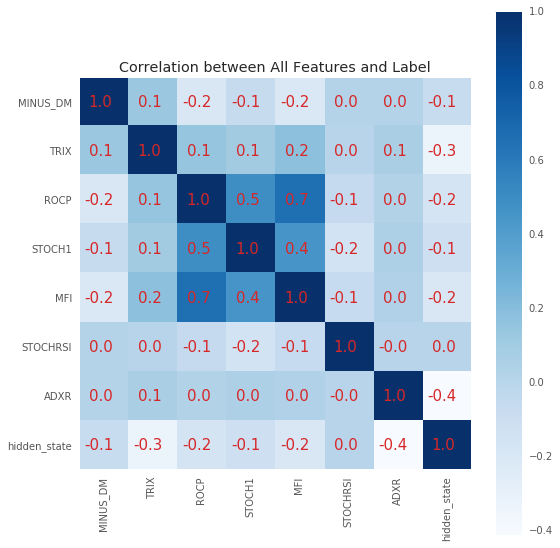

In [5]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=15);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=15);
                
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(8,8))
    plot_correlation_matrix(dataset2.corr(), 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    
    #plt.savefig(os.path.join(batch,"correlation.png"), dpi=200)


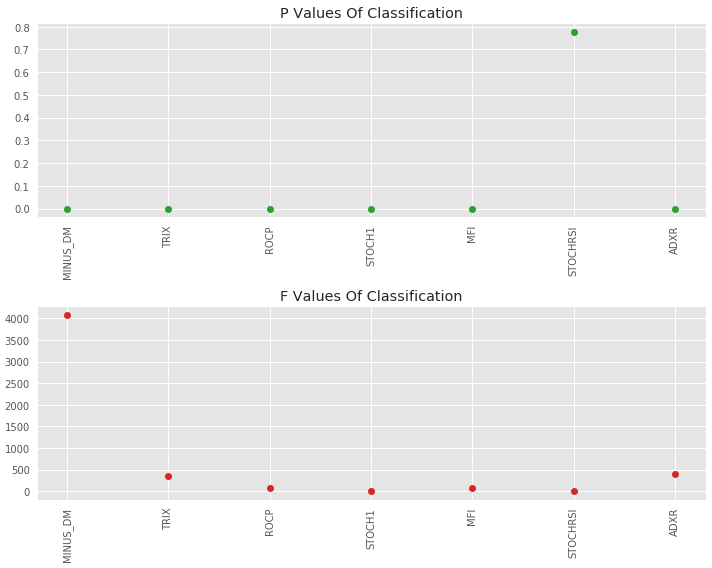

In [6]:
X = dataset2.drop(columns=["hidden_state", "Time"])
X = MinMaxScaler().fit_transform(X)
Y = dataset2['hidden_state'].values
#Y = np.array([1 if y==1 else 0 for y in Y])

cols = dataset2.drop(columns=["Time", "hidden_state"]).columns

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(212)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('F Values Of Classification');
    
    plt.tight_layout()
    
    #plt.savefig(os.path.join(batch,"f_p_values.png"), dpi=200)

### Hidden Set Trend

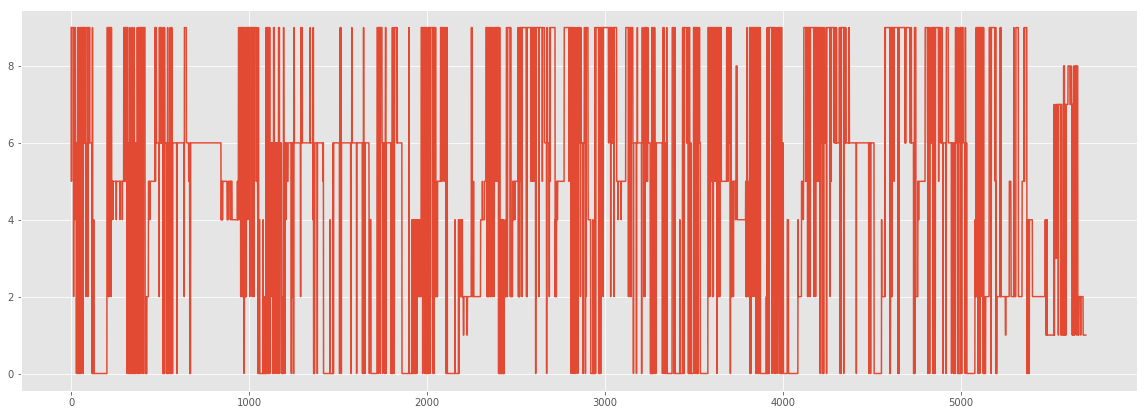

In [7]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(20,7))
    plt.plot(dataset2.hidden_state)

## ML/DL Algorithms

In [36]:
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        if "val_loss" in hist.history:
            plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            if "val_accuracy" in hist.history:
                plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')
            
def print_plot_metrics(model_name, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    conf_mat = confusion_matrix(Y_test, predictions)
    print('Confusion Matrix : \n', conf_mat)
    #plot_confusion_matrix(conf_mat)
    
def plot_confusion_matrix(conf_mat):
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks([0, 1], [-1, 1])
        plt.yticks([0, 1], [-1, 1])
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')

In [9]:
batch = "BTCUSD_Dataset2"

if not os.path.exists(batch):
    os.mkdir(batch)

X = dataset2.drop(columns = ["hidden_state", "Time"]).values
Y = dataset2["hidden_state"].values

print("Are there any NA in dataset? : {}".format(not np.alltrue(np.any(X))))

X.shape, Y.shape

Are there any NA in dataset? : False


((5704, 7), (5704,))

In [31]:
lookback = 3 ## Number of examples to lookback to make decision about future.

X_new, Y_new = [],[]

for i in range(X.shape[0] - lookback):
    X_new.append(X[i: i+lookback])
    Y_new.append(Y[i+lookback])
    
X_new, Y_new = np.array(X_new), np.array(Y_new)

print("Dataet Size : ",X_new.shape, Y_new.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, 
                                                    train_size=0.98, 
                                                    shuffle=False)

print("\nTrain/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print("\nClass Distribution (Y_train) : ")
for cls in np.unique(Y_train):
    print("{} : {}".format(cls, Y_train.tolist().count(cls)))

print("\nClass Distribution (Y_test) : ")
for cls in np.unique(Y_test):
    print("{} : {}".format(cls, Y_test.tolist().count(cls)))

Y_train_cat, Y_test_cat = keras.utils.to_categorical(Y_train), keras.utils.to_categorical(Y_test, num_classes=10)

Y_train_cat.shape, Y_test_cat.shape

Dataet Size :  (5699, 5, 7) (5699,)

Train/Test Sizes :  (5585, 5, 7) (114, 5, 7) (5585,) (114,)

Class Distribution (Y_train) : 
0 : 1037
1 : 69
2 : 560
3 : 12
4 : 267
5 : 528
6 : 1501
7 : 31
8 : 11
9 : 1569

Class Distribution (Y_test) : 
1 : 34
2 : 25
7 : 25
8 : 30


((5585, 10), (114, 10))

## LSTM v1

In [32]:
lstm_classif_v1 = Sequential([
                        LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.1),
                        Dense(Y_train_cat.shape[1], activation='softmax')                        
                        ])

print(lstm_classif_v1.summary())

#plot_model(lstm_classif_v1, to_file=os.path.join(batch, 'lstm_classif1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif1.png'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               94800     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1510      
Total params: 96,310
Trainable params: 96,310
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
lstm_classif_v1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v1.fit(X_train, Y_train_cat, epochs=100, batch_size=8, verbose=2, shuffle=False)

Epoch 1/100
699/699 - 3s - loss: 1.6689 - accuracy: 0.4005
Epoch 2/100
699/699 - 2s - loss: 1.5078 - accuracy: 0.4424
Epoch 3/100
699/699 - 3s - loss: 1.4552 - accuracy: 0.4614
Epoch 4/100
699/699 - 3s - loss: 1.4178 - accuracy: 0.4691
Epoch 5/100
699/699 - 2s - loss: 1.4026 - accuracy: 0.4809
Epoch 6/100
699/699 - 3s - loss: 1.3927 - accuracy: 0.4781
Epoch 7/100
699/699 - 3s - loss: 1.4017 - accuracy: 0.4782
Epoch 8/100
699/699 - 3s - loss: 1.3898 - accuracy: 0.4849
Epoch 9/100
699/699 - 3s - loss: 1.4122 - accuracy: 0.4822
Epoch 10/100
699/699 - 3s - loss: 1.3900 - accuracy: 0.4872
Epoch 11/100
699/699 - 3s - loss: 1.4040 - accuracy: 0.4811
Epoch 12/100
699/699 - 3s - loss: 1.3783 - accuracy: 0.4919
Epoch 13/100
699/699 - 3s - loss: 1.3562 - accuracy: 0.4985
Epoch 14/100
699/699 - 3s - loss: 1.3345 - accuracy: 0.4954
Epoch 15/100
699/699 - 3s - loss: 1.3377 - accuracy: 0.5010
Epoch 16/100
699/699 - 3s - loss: 1.3128 - accuracy: 0.5119
Epoch 17/100
699/699 - 3s - loss: 1.2943 - accura

In [37]:
plot_loss_and_accuracy(history)

In [39]:
predictions = lstm_classif_v1.predict_classes(X_test)

print('Test Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('LSTMV1', Y_test, predictions)

Test Accuracy : 0.412

Classification Report : 
               precision    recall  f1-score   support

           1       0.31      0.82      0.46        34
           2       0.76      0.76      0.76        25
           7       0.00      0.00      0.00        25
           8       0.00      0.00      0.00        30

    accuracy                           0.41       114
   macro avg       0.27      0.40      0.30       114
weighted avg       0.26      0.41      0.30       114

Confusion Matrix : 
 [[28  6  0  0]
 [ 6 19  0  0]
 [25  0  0  0]
 [30  0  0  0]]


## LSTM v2

In [40]:
lstm_classif_v2 = Sequential([
                LSTM(units=100, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=50, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train_cat.shape[1], activation='softmax')
                ])

print(lstm_classif_v2.summary())

#plot_model(lstm_classif_v2, to_file=os.path.join(batch, 'lstm_classif2.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif2.png'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 100)            43200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             30200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 83,430
Trainable params: 83,430
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
lstm_classif_v2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v2.fit(X_train, Y_train_cat, epochs=100, batch_size=8, verbose=2, shuffle=False)

Epoch 1/100
699/699 - 3s - loss: 1.6673 - accuracy: 0.3681
Epoch 2/100
699/699 - 3s - loss: 1.5249 - accuracy: 0.4145
Epoch 3/100
699/699 - 3s - loss: 1.4410 - accuracy: 0.4190
Epoch 4/100
699/699 - 3s - loss: 1.4223 - accuracy: 0.4188
Epoch 5/100
699/699 - 3s - loss: 1.4009 - accuracy: 0.4440
Epoch 6/100
699/699 - 3s - loss: 1.3806 - accuracy: 0.4501
Epoch 7/100
699/699 - 3s - loss: 1.3837 - accuracy: 0.4521
Epoch 8/100
699/699 - 3s - loss: 1.3602 - accuracy: 0.4585
Epoch 9/100
699/699 - 3s - loss: 1.3592 - accuracy: 0.4541
Epoch 10/100
699/699 - 3s - loss: 1.3423 - accuracy: 0.4661
Epoch 11/100
699/699 - 3s - loss: 1.3314 - accuracy: 0.4702
Epoch 12/100
699/699 - 3s - loss: 1.3216 - accuracy: 0.4910
Epoch 13/100
699/699 - 3s - loss: 1.3416 - accuracy: 0.4630
Epoch 14/100
699/699 - 3s - loss: 1.3152 - accuracy: 0.4763
Epoch 15/100
699/699 - 3s - loss: 1.3191 - accuracy: 0.4611
Epoch 16/100
699/699 - 3s - loss: 1.3358 - accuracy: 0.4607
Epoch 17/100
699/699 - 3s - loss: 1.3146 - accura

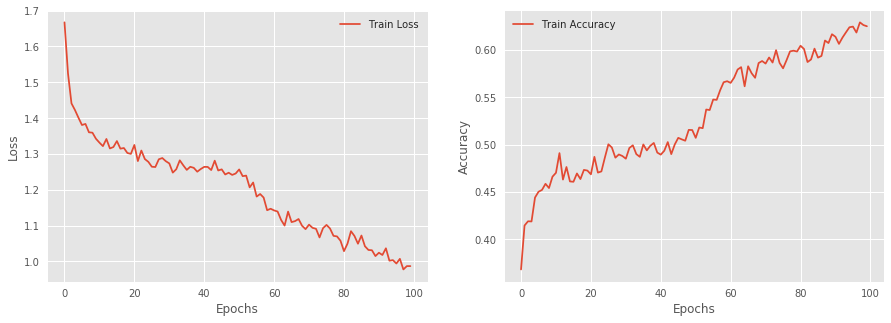

In [42]:
plot_loss_and_accuracy(history)

In [43]:
predictions = lstm_classif_v2.predict_classes(X_test)

print('Test Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('LSTMV2', Y_test, predictions)

Test Accuracy : 0.447

Classification Report : 
               precision    recall  f1-score   support

           1       0.50      0.47      0.48        34
           2       0.48      0.60      0.54        25
           7       0.39      0.80      0.53        25
           8       0.00      0.00      0.00        30

    accuracy                           0.45       114
   macro avg       0.34      0.47      0.39       114
weighted avg       0.34      0.45      0.38       114

Confusion Matrix : 
 [[16  9  9  0]
 [10 15  0  0]
 [ 2  3 20  0]
 [ 4  4 22  0]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


## CNN LSTM

In [44]:
lstm_classif_v3 = Sequential([
    TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, X_train.shape[1], X_train.shape[2])),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(100, activation='relu'),
    Dense(Y_train_cat.shape[1], activation='softmax')
])


print(lstm_classif_v3.summary())

#plot_model(lstm_classif_v3, to_file=os.path.join(batch, 'lstm_classif3.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif3.png'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 5, 32)       256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 32)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 67,266
Trainable params: 67,266
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
lstm_classif_v3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v3.fit(X_train.reshape(X_train.shape[0],1,X_train.shape[1], X_train.shape[2]), Y_train_cat, epochs=100, batch_size=8, verbose=2, shuffle=False)

Epoch 1/10
699/699 - 1s - loss: 4.3559 - accuracy: 0.3298
Epoch 2/10
699/699 - 1s - loss: 2.0614 - accuracy: 0.3767
Epoch 3/10
699/699 - 1s - loss: 1.7004 - accuracy: 0.3751
Epoch 4/10
699/699 - 1s - loss: 1.6411 - accuracy: 0.3936
Epoch 5/10
699/699 - 1s - loss: 1.6517 - accuracy: 0.3928
Epoch 6/10
699/699 - 1s - loss: 1.5637 - accuracy: 0.4100
Epoch 7/10
699/699 - 1s - loss: 1.5682 - accuracy: 0.4013
Epoch 8/10
699/699 - 1s - loss: 1.5457 - accuracy: 0.4030
Epoch 9/10
699/699 - 1s - loss: 1.5371 - accuracy: 0.4143
Epoch 10/10
699/699 - 1s - loss: 1.5237 - accuracy: 0.4041


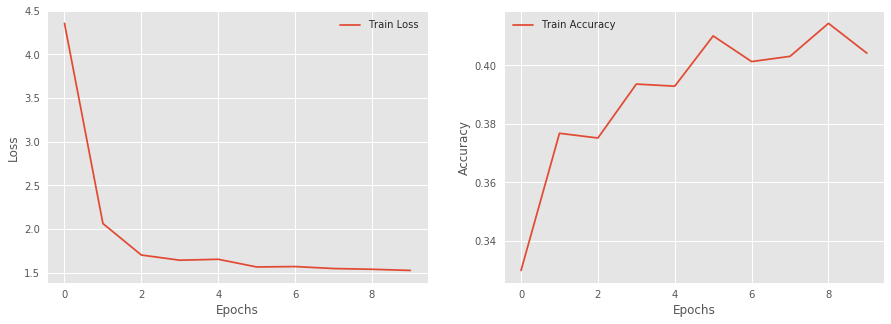

In [46]:
plot_loss_and_accuracy(history)

In [47]:
predictions = lstm_classif_v3.predict_classes(X_test.reshape(X_test.shape[0],1,X_test.shape[1], X_test.shape[2]))

print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

print_plot_metrics('CNN_LSTM', Y_test, predictions)

Accuracy : 0.000
Classification Report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00      34.0
           2       0.00      0.00      0.00      25.0
           7       0.00      0.00      0.00      25.0
           8       0.00      0.00      0.00      30.0
           9       0.00      0.00      0.00       0.0

    accuracy                           0.00     114.0
   macro avg       0.00      0.00      0.00     114.0
weighted avg       0.00      0.00      0.00     114.0

Confusion Matrix : 
 [[ 0  0  0  0 34]
 [ 0  0  0  0 25]
 [ 0  0  0  0 25]
 [ 0  0  0  0 30]
 [ 0  0  0  0  0]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


## ConvLSTM

In [48]:
lstm_classif_v4 = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(Y_train_cat.shape[1], activation='softmax')
])


print(lstm_classif_v4.summary())

#plot_model(lstm_classif_v4, to_file=os.path.join(batch, 'lstm_classif4.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif4.png'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 4, 64)          36608     
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 39,178
Trainable params: 39,178
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
lstm_classif_v4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v4.fit(X_train.reshape(X_train.shape[0],1, 1, X_train.shape[1], X_train.shape[2]), Y_train_cat, epochs=100, batch_size=8, verbose=2, shuffle=False)

Epoch 1/3
699/699 - 1s - loss: 5.0403 - accuracy: 0.3644
Epoch 2/3
699/699 - 1s - loss: 1.7378 - accuracy: 0.3939
Epoch 3/3
699/699 - 1s - loss: 1.6321 - accuracy: 0.4201


In [50]:
plot_loss_and_accuracy(history)

In [51]:
predictions = lstm_classif_v4.predict_classes(X_test.reshape(X_test.shape[0],1,1,X_test.shape[1], X_test.shape[2]))

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('CONV_LSTM', Y_test, predictions)

Accuracy : 0.000

Classification Report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00      34.0
           2       0.00      0.00      0.00      25.0
           7       0.00      0.00      0.00      25.0
           8       0.00      0.00      0.00      30.0
           9       0.00      0.00      0.00       0.0

    accuracy                           0.00     114.0
   macro avg       0.00      0.00      0.00     114.0
weighted avg       0.00      0.00      0.00     114.0

Confusion Matrix : 
 [[ 0  0  0  0 34]
 [ 0  0  0  0 25]
 [ 0  0  0  0 25]
 [ 0  0  0  0 30]
 [ 0  0  0  0  0]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


## XGB Classifier

In [52]:
X_new, Y_new = X[:-1], Y[1:] ## Lookback is 1 in case of XGB and Dense nets. It can only support that.

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, 
                                                    train_size=0.97, 
                                                    shuffle=False,
                                                    )

print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print("\nClass Distribution (Y_train) : ")
for cls in np.unique(Y_train):
    print("{} : {}".format(cls, Y_train.tolist().count(cls)))

print("\nClass Distribution (Y_test) : ")
for cls in np.unique(Y_test):
    print("{} : {}".format(cls, Y_test.tolist().count(cls)))

Y_train_cat, Y_test_cat = keras.utils.to_categorical(Y_train), keras.utils.to_categorical(Y_test)

Y_train_cat.shape, Y_test_cat.shape

Train/Test Sizes :  (5531, 7) (172, 7) (5531,) (172,)

Class Distribution (Y_train) : 
0 : 1037
1 : 52
2 : 560
3 : 5
4 : 267
5 : 529
6 : 1501
7 : 1
8 : 7
9 : 1572

Class Distribution (Y_test) : 
1 : 51
2 : 25
3 : 7
7 : 55
8 : 34


((5531, 10), (172, 9))

In [53]:
xgb_classif = xgb.XGBClassifier(n_estimators=250, max_depth=2, objective="multi:softmax", num_class=5)

xgb_classif.fit(X_train, Y_train, verbose=10)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
predictions = xgb_classif.predict(X_test)

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('XGBClassifier', Y_test, predictions)

Accuracy : 0.314

Classification Report : 
               precision    recall  f1-score   support

           1       0.31      0.55      0.40        51
           2       0.30      0.88      0.44        25
           3       0.57      0.57      0.57         7
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00        55
           8       0.00      0.00      0.00        34

    accuracy                           0.31       172
   macro avg       0.20      0.33      0.24       172
weighted avg       0.16      0.31      0.21       172

Confusion Matrix : 
 [[28 23  0  0  0  0]
 [ 3 22  0  0  0  0]
 [ 3  0  4  0  0  0]
 [ 0  0  0  0  0  0]
 [31 21  3  0  0  0]
 [25  8  0  1  0  0]]


### LIME Interpretation

In [55]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = xgb_classif.predict(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset2.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_classif.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 7
Prediction   : 1

Intercept 0.24383889456297406
Prediction_local [0.22168095]
Right: 1.2944277e-05
Intercept -0.014970795337428084
Prediction_local [0.11767221]
Right: 0.675509
Intercept 0.04179718521648368
Prediction_local [0.57416128]
Right: 0.32172284
Intercept 9.59198479933253e-05
Prediction_local [4.88121822e-05]
Right: 1.5071016e-05
Intercept 0.06775779968672618
Prediction_local [0.14946586]
Right: 0.001207466


## XGB RF Classifier

In [56]:
xgb_rf_classif = xgb.XGBRFClassifier(n_estimators=250, max_depth=2, objective="multi:softmax", num_class=5)

xgb_rf_classif.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=10)

[0]	validation_0-merror:0.73837


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=1, max_delta_step=0, max_depth=2,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=250, n_jobs=0, num_class=5, num_parallel_tree=250,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=None, subsample=0.8,
                tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
predictions = xgb_rf_classif.predict(X_test)

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('XGBClassifier', Y_test, predictions)

Accuracy : 0.262

Classification Report : 
               precision    recall  f1-score   support

           1       0.24      0.39      0.30        51
           2       0.32      1.00      0.49        25
           3       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        55
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00         0

    accuracy                           0.26       172
   macro avg       0.09      0.23      0.13       172
weighted avg       0.12      0.26      0.16       172

Confusion Matrix : 
 [[20 24  0  0  0  7]
 [ 0 25  0  0  0  0]
 [ 3  4  0  0  0  0]
 [37 14  0  0  0  4]
 [24 10  0  0  0  0]
 [ 0  0  0  0  0  0]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


### LIME Interpretation

In [58]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = xgb_rf_classif.predict(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset2.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_rf_classif.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 7
Prediction   : 1

Intercept 0.09546385814880932
Prediction_local [0.32132675]
Right: 0.026124692
Intercept 0.02939149794301439
Prediction_local [0.04318425]
Right: 0.4537538
Intercept 0.022457187444898413
Prediction_local [0.47501626]
Right: 0.28300747
Intercept 0.029698009577765094
Prediction_local [0.02490988]
Right: 0.062846385
Intercept 0.04297407588935149
Prediction_local [0.03712322]
Right: 0.009851857


## Dense Nets

In [61]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(),      
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.2),
                     Dense(10,   activation='softmax')])

print(dense_model1.summary())
#plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'dense1.png'))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [62]:
dense_model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = dense_model1.fit(X_train, Y_train_cat, batch_size=8, epochs=100, verbose=1,shuffle=False, use_multiprocessing=True);

Epoch 1/100
692/692 [==============================] - 0s 615us/step - loss: 5.2455 - accuracy: 0.2425
Epoch 2/100
692/692 [==============================] - 1s 733us/step - loss: 2.0531 - accuracy: 0.2920
Epoch 3/100
692/692 [==============================] - 0s 625us/step - loss: 1.8560 - accuracy: 0.3524
Epoch 4/100
692/692 [==============================] - 0s 658us/step - loss: 1.7666 - accuracy: 0.3690
Epoch 5/100
692/692 [==============================] - 0s 665us/step - loss: 1.6941 - accuracy: 0.3833
Epoch 6/100
692/692 [==============================] - 0s 684us/step - loss: 1.6654 - accuracy: 0.3893
Epoch 7/100
692/692 [==============================] - 0s 617us/step - loss: 1.6196 - accuracy: 0.3956
Epoch 8/100
692/692 [==============================] - 1s 832us/step - loss: 1.5968 - accuracy: 0.3978
Epoch 9/100
692/692 [==============================] - 0s 651us/step - loss: 1.5961 - accuracy: 0.3920
Epoch 10/100
692/692 [==============================] - 0s 605us/step - l

692/692 [==============================] - 0s 545us/step - loss: 1.2696 - accuracy: 0.5334
Epoch 80/100
692/692 [==============================] - 0s 564us/step - loss: 1.2517 - accuracy: 0.5305
Epoch 81/100
692/692 [==============================] - 0s 547us/step - loss: 1.2720 - accuracy: 0.5359
Epoch 82/100
692/692 [==============================] - 0s 542us/step - loss: 1.2546 - accuracy: 0.5372
Epoch 83/100
692/692 [==============================] - 0s 558us/step - loss: 1.2556 - accuracy: 0.5435
Epoch 84/100
692/692 [==============================] - 0s 543us/step - loss: 1.2511 - accuracy: 0.5382
Epoch 85/100
692/692 [==============================] - 0s 542us/step - loss: 1.2526 - accuracy: 0.5346
Epoch 86/100
692/692 [==============================] - 1s 726us/step - loss: 1.2447 - accuracy: 0.5305
Epoch 87/100
692/692 [==============================] - 0s 707us/step - loss: 1.2724 - accuracy: 0.5370
Epoch 88/100
692/692 [==============================] - 1s 879us/step - loss:

In [63]:
plot_loss_and_accuracy(history)

In [64]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('DenseNetv1', Y_test, predictions)

Accuracy : 0.285

Classification Report : 
               precision    recall  f1-score   support

           1       0.23      0.47      0.31        51
           2       0.37      1.00      0.54        25
           3       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        55
           8       0.00      0.00      0.00        34

    accuracy                           0.28       172
   macro avg       0.12      0.29      0.17       172
weighted avg       0.12      0.28      0.17       172

Confusion Matrix : 
 [[24 27  0  0  0]
 [ 0 25  0  0  0]
 [ 7  0  0  0  0]
 [52  3  0  0  0]
 [21 13  0  0  0]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


### LIME Interpretation

In [65]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = dense_model1.predict_classes(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset2.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    dense_model1.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 7
Prediction   : 1

Instructions for updating:
Please use `model.predict()` instead.
Intercept 0.365942956162147
Prediction_local [-0.01245658]
Right: 6.2091372e-30
Intercept -0.0005833561259369555
Prediction_local [0.13486002]
Right: 0.6998849
Intercept 0.07594652357868745
Prediction_local [0.58341168]
Right: 0.055172194
Intercept -0.0004287045721336948
Prediction_local [0.0242418]
Right: 0.24294387
Intercept 0.044433488960979275
Prediction_local [0.1048696]
Right: 0.0006690674
